In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math
from scipy.stats.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf
df=pd.read_csv("daily_covid_cases.csv")

<ipython-input-2-ae78712542dc>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


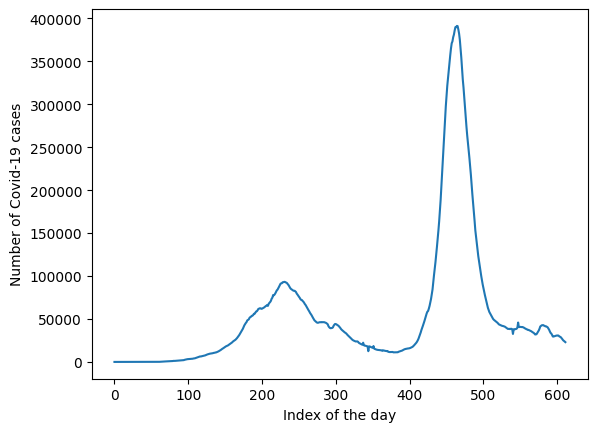

In [4]:
'''A line plot with the x-axis as index of the day and y-axis as the number of Covid-19 cases'''
plt.plot(df["new_cases"])
plt.xlabel('Index of the day')
plt.ylabel('Number of Covid-19 cases')
plt.show()

In [21]:
'''Generating another time sequence with a one-day lag to the given time sequence and finding
the Pearson correlation (autocorrelation) coefficient between the generated one-day lag time
sequence and the given time sequence.'''
df["One_Day_lag"] = df["new_cases"].shift(1)
Correlation=df["One_Day_lag"].corr(df["new_cases"])
print(Correlation)

0.9990644144715026


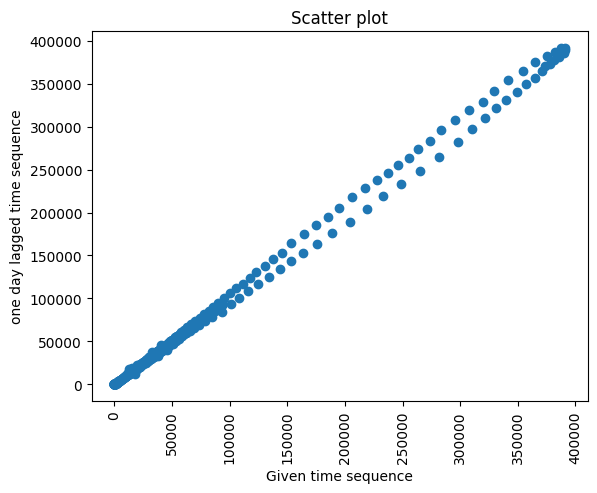

In [23]:
#. Generate a scatter plot between the given time sequence and one-day lagged generated sequence
plt.scatter(df["new_cases"],df["One_Day_lag"])
plt.xticks(rotation=90)
plt.xlabel("Given time sequence")
plt.ylabel("one day lagged time sequence")
plt.title("Scatter plot")
plt.show()
del df["One_Day_lag"]

We can clearly see through the graph too that they are highly correlated

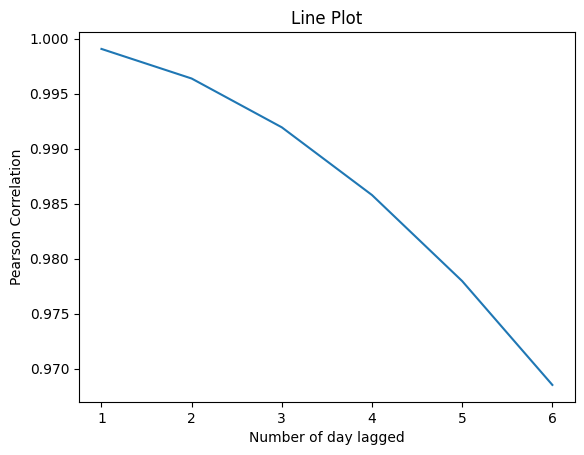

In [7]:
'''Generating multiple time sequences with different lag values (1-day, 2-days, 3-days up to 6-
days). Compute the Pearson correlation coefficient between each of the generated time
sequences and the given time sequence.
Create a line plot between obtained correlation
coefficients (on the y-axis) and lagged values (on the x-axis)'''
l=[1,2,3,4,5,6]
Correlation=[]
for i in range(len(l)):
    df["Day_lag"] = df["new_cases"].shift(l[i])
    Correlation.append(df["Day_lag"].corr(df["new_cases"]))
del df["Day_lag"]
plt.plot(l,Correlation)
plt.ylabel("Pearson Correlation")
plt.xlabel("Number of day lagged")
plt.title("Line Plot")
plt.show()

We can say that correlaion is decreasing as we are increasing the lag

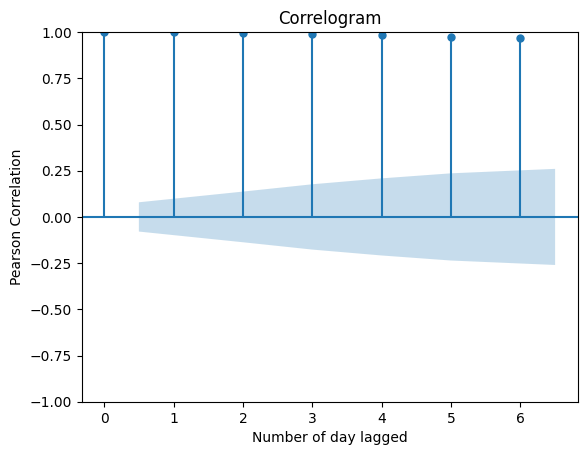

In [8]:
'''Plot a correlogram or Auto Correlation Function using python inbuilt function
‘plot_acf’. Observe the trend in the line plot with increase in lagged values and relate'''
plot_acf(df["new_cases"],lags=6)      #plotting correlation coefficient using inbuilt plot_acf function
plt.xlabel('Number of day lagged')
plt.ylabel('Pearson Correlation')
plt.title('Correlogram')
plt.show()

A general autoregression (AR) model estimates the unknown data values as a linear
combination of given lagged data values. For example, data value at (t+1) instant, denoted by
x(t+1), can be estimated from its previous instance values, such as x(t+1) = w0 + w1*x(t) +
w2*x(t-1) + … + wp*x(t-p+1). The coefficients w0, w1, … wp can be estimated while training
the autoregression model on training dataset

In [9]:
'''Split the data into two parts. The initial 65% of the sequence for training data and the
remaining 35% of the sequence as test data.'''

'''Use 5 lagged values as its input (p=5).
Train/Fit the model onto the training dataset. Obtain the coefficients (w0, w1, ..., wp) from
the trained AR model.'''

df=pd.read_csv('daily_covid_cases.csv',parse_dates=['Date'],index_col=['Date'],sep=',')
test_size=0.35
X=df.values
tst_sz=math.ceil(len(X)*test_size)
train,test=X[:len(X)-tst_sz],X[len(X)-tst_sz:]
model_fit = AutoReg(train,lags=5,old_names=False).fit()
coef = model_fit.params
print("The coeffiecient of AR generated model")
print(coef)

The coeffiecient of AR generated model
[ 5.99548333e+01  1.03675933e+00  2.61712336e-01  2.75612628e-02
 -1.75391955e-01 -1.52461366e-01]


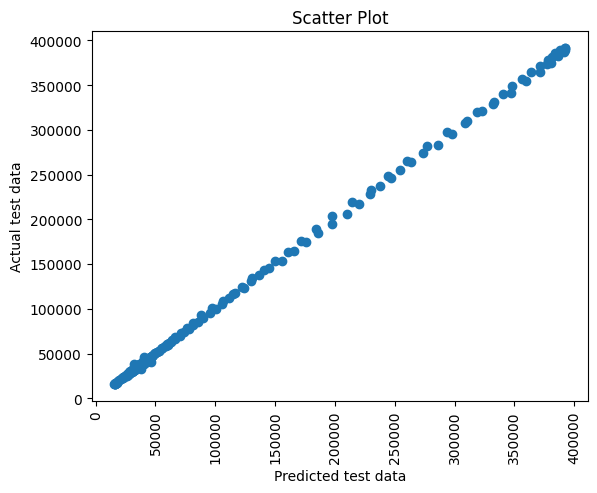

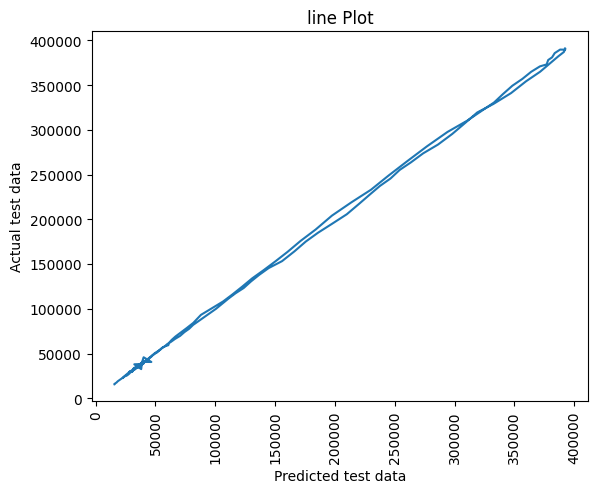

RMSE between actual and predicted test data is: [1.82476848]
MAPE between actual and predicted test data 0.01574836382405824


In [25]:
#Code snippet to train AR model and predict using the coefficients
def AR(p):
    model_fit = AutoReg(train,lags=p,old_names=False).fit()
    coef = model_fit.params
    history=train[len(train)-p:]
    history=[history[i] for i in range(len(history))]
    predictions=[]
    for t in range(len(test)):
        length=len(history)
        lag=[history[i] for i in range(length-p,length)]
        yhat=coef[0]
        for d in range(p):
            yhat+=coef[d+1]*lag[p-d-1]
        obs=test[t]
        predictions.append(yhat)
        history.append(obs)
    RMSE=(mean_squared_error(test,predictions))**(0.5)*100/(sum(test)/len(test))
    MAPE=mean_absolute_percentage_error(test,predictions)
    return [RMSE,MAPE]

#Using the above calculated coefficients to predict the values (using the relation given above) for the test dataset.
p=5
history=train[len(train)-p:]
history=[history[i] for i in range(len(history))]
predictions=[]
for t in range(len(test)):
    length=len(history)
    lag=[history[i] for i in range(length-p,length)]
    yhat=coef[0]
    for d in range(p):
        yhat+=coef[d+1]*lag[p-d-1]
    obs=test[t]
    predictions.append(yhat)
    history.append(obs)
#Scatter plot to distinguish the predicted and actual values
plt.scatter(predictions,test)
plt.xticks(rotation=90)
plt.xlabel("Predicted test data")
plt.ylabel("Actual test data")
plt.title("Scatter Plot")
plt.show()

#Line plot to distinguish the predicted and actual values
plt.plot(predictions,test)
plt.xticks(rotation=90)
plt.xlabel("Predicted test data")
plt.ylabel("Actual test data")
plt.title("line Plot")
plt.show()

# RMSE (%) and MAPE between actual and predicted test data.
print("RMSE between actual and predicted test data is:",AR(5)[0])
MAPE=mean_absolute_percentage_error(test,predictions)
print("MAPE between actual and predicted test data",AR(5)[1])

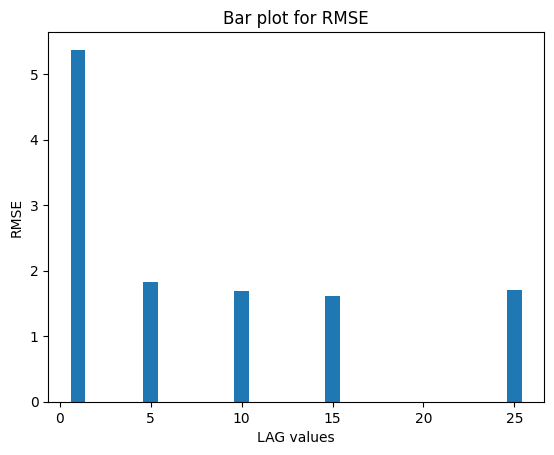

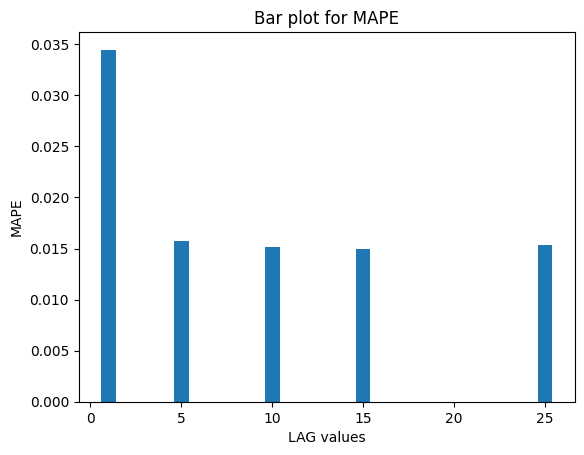

In [12]:
'''Generate five AR models using AutoReg() function with lag values as 1, 5, 10, 15 and 25
days. Compute the RMSE (%) and MAPE between predicted and original test data values in
each case. Give a bar chart showing RMSE (%) on the y-axis and lagged values on the x-axis.
Also, give a bar chart showing MAPE on the y-axis and lagged values on the x-axis. Infer the
changes in RMSE (%) and MAPE with changes in lagged values.'''
MAPE=[]
RMSE=[]
p=[1,5,10,15,25]
for i in p:
    t=AR(i)
    RMSE.append(t[0][0])
    MAPE.append(t[1])
# print(RMSE)
# print(MAPE)
plt.bar(p,RMSE)
plt.xlabel("LAG values")
plt.ylabel("RMSE")
plt.title("Bar plot for RMSE")
plt.show()
plt.bar(p,MAPE)
plt.ylabel("MAPE")
plt.xlabel("LAG values")
plt.title("Bar plot for MAPE")
plt.show()

 Compute the heuristic value for the optimal number of lags up to the condition on
autocorrelation such that abs(AutoCorrelation) > 2/sqrt(T), where T is the number of
observations in training data. Use it as input in AutoReg() function to predict the new
COVID-19 cases on daily basis and compute the RMSE(%) and MAPE value

In [13]:
for i in range(1,100):
    df["Day_lag"] = df["new_cases"].shift(i)
    corr=df["Day_lag"].corr(df["new_cases"])
    if(abs(corr)<2/(len(train)**0.5)):
     heurestic=i-1
     break
print(f'The heurestic value for time lag is {heurestic}')
T=AR(heurestic)
print("The RMSE for heurestic value as time lag is",T[0])
print("The MAPE for heurestic value as time lag is",T[1])

The heurestic value for time lag is 47
The RMSE for heurestic value as time lag is [1.70831664]
The MAPE for heurestic value as time lag is 0.016371556982291393


In [29]:
'''Split the data into two parts. The initial 65% of the sequence for training data and the
remaining 35% of the sequence as test data.'''

'''Use 47 lagged values as its input (p=5).
Train/Fit the model onto the training dataset. Obtain the coefficients (w0, w1, ..., wp) from
the trained AR model.'''

df=pd.read_csv('daily_covid_cases.csv',parse_dates=['Date'],index_col=['Date'],sep=',')
test_size=0.35
X=df.values
tst_sz=math.ceil(len(X)*test_size)
train,test=X[:len(X)-tst_sz],X[len(X)-tst_sz:]
model_fit = AutoReg(train,lags=47,old_names=False).fit()
coef = model_fit.params
print("The coeffiecient of AR generated model")
print(coef)

The coeffiecient of AR generated model
[ 8.43359878e+01  1.21513680e+00  6.72460648e-02 -2.20644118e-02
 -1.31551648e-01 -5.47902088e-03  7.10473779e-02 -1.16904109e+00
  1.31142311e+00 -1.50074447e-01 -1.75079800e-02 -1.43178612e-01
  1.99186435e-02  1.45205595e-01 -1.01566234e+00  1.17468982e+00
 -2.91836719e-01  7.75623554e-02 -1.03100655e-01  4.19092852e-02
  9.20299582e-02 -7.68661041e-01  8.91581547e-01 -3.65457710e-01
  1.23056072e-01 -1.05335773e-01  7.26632774e-02  1.33913401e-01
 -5.18790957e-01  6.74122894e-01 -3.69829842e-01  1.76851106e-01
 -1.75412384e-01  4.24837442e-02  9.95559526e-02 -3.02408504e-01
  4.12986648e-01 -2.88163170e-01  1.79607352e-01 -1.06736341e-01
  3.15047398e-02  1.59537429e-02 -9.91911616e-02  1.75366173e-01
 -1.41609373e-01  7.69749482e-02 -5.80877442e-02  2.38512032e-02]


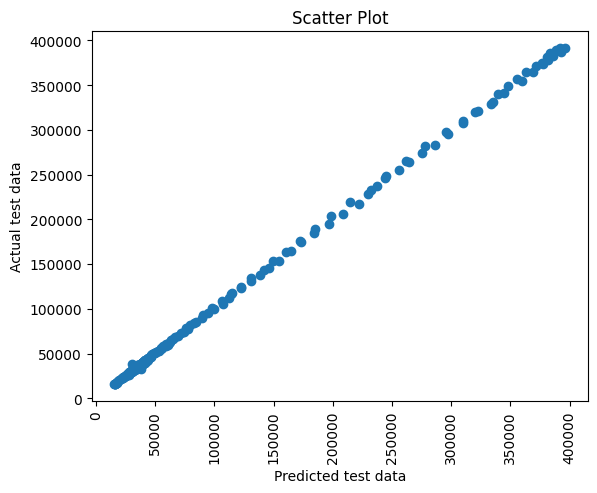

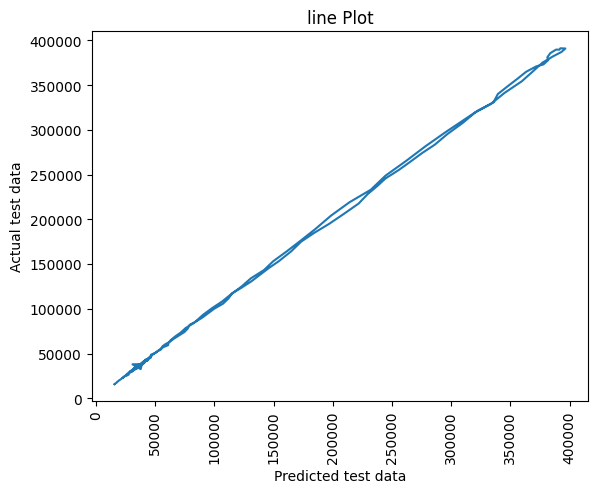

RMSE between actual and predicted test data is: [1.70831664]
MAPE between actual and predicted test data 0.016371556982291393


In [31]:
#Code snippet to train AR model and predict using the coefficients
def AR(p):
    model_fit = AutoReg(train,lags=p,old_names=False).fit()
    coef = model_fit.params
    history=train[len(train)-p:]
    history=[history[i] for i in range(len(history))]
    predictions=[]
    for t in range(len(test)):
        length=len(history)
        lag=[history[i] for i in range(length-p,length)]
        yhat=coef[0]
        for d in range(p):
            yhat+=coef[d+1]*lag[p-d-1]
        obs=test[t]
        predictions.append(yhat)
        history.append(obs)
    RMSE=(mean_squared_error(test,predictions))**(0.5)*100/(sum(test)/len(test))
    MAPE=mean_absolute_percentage_error(test,predictions)
    return [RMSE,MAPE]


p=47
history=train[len(train)-p:]
history=[history[i] for i in range(len(history))]
predictions=[]
for t in range(len(test)):
    length=len(history)
    lag=[history[i] for i in range(length-p,length)]
    yhat=coef[0]
    for d in range(p):
        yhat+=coef[d+1]*lag[p-d-1]
    obs=test[t]
    predictions.append(yhat)
    history.append(obs)
#Scatter plot to distinguish the predicted and actual values
plt.scatter(predictions,test)
plt.xticks(rotation=90)
plt.xlabel("Predicted test data")
plt.ylabel("Actual test data")
plt.title("Scatter Plot")
plt.show()

#Line plot to distinguish the predicted and actual values
plt.plot(predictions,test)
plt.xticks(rotation=90)
plt.xlabel("Predicted test data")
plt.ylabel("Actual test data")
plt.title("line Plot")
plt.show()

# RMSE (%) and MAPE between actual and predicted test data.
print("RMSE between actual and predicted test data is:",AR(47)[0])
MAPE=mean_absolute_percentage_error(test,predictions)
print("MAPE between actual and predicted test data",AR(47)[1])